# 영업 성공 여부 분류 경진대회

# 0. ⭕ 필수 라이브러리

In [ ]:
!pip install catboost
!pip install ipywidgets
import ipywidgets as widgets
widgets.IntSlider()

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


IntSlider(value=0)

In [ ]:
# 사용 라이브러리
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.utils.class_weight import compute_class_weight # 가중치 부여

import math
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_curve, auc

#모델 라이브러리
from catboost import CatBoostClassifier, Pool

## 데이터 셋 읽어오기

In [ ]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

# submission 제출하면서 저장된 열 삭제
if 'is_converted' in df_test.columns:
    df_test.drop(['is_converted'], axis=1, inplace=True)

# 1. ⭕ EDA

In [ ]:
# train data 컬럼 별 유형 확인
print('df_train information')
print(df_train.info())
print()

# test data 컬럼 별 유형 확인
print('df_test information')
print(df_test.info())

df_train information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59299 entries, 0 to 59298
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              59299 non-null  float64
 1   customer_country         58317 non-null  object 
 2   business_unit            59299 non-null  object 
 3   com_reg_ver_win_rate     14568 non-null  float64
 4   customer_idx             59299 non-null  int64  
 5   customer_type            15338 non-null  object 
 6   enterprise               59299 non-null  object 
 7   historical_existing_cnt  13756 non-null  float64
 8   id_strategic_ver         3444 non-null   float64
 9   it_strategic_ver         1121 non-null   float64
 10  idit_strategic_ver       4565 non-null   float64
 11  customer_job             40566 non-null  object 
 12  lead_desc_length         59299 non-null  int64  
 13  inquiry_type             58358 non-null  object 
 14  p

In [ ]:
# 기본적인 전처리와 EDA를 진행하기 위해 train data와 test data를 합치고, 이를 구분할 수 있도록 index 저장
data = pd.concat([df_train,df_test])
data.index = range(len(data))
train_index = range(len(df_train))
test_index = range(len(df_train),len(data))

# 수치형 컬럼과 범주형 컬럼 구분 (id 와, Target columns 제외)
numeric_columns = list(data.drop(['id','is_converted'],axis=1).select_dtypes(include='number').columns)
categorical_columns = list(data.drop(['id','is_converted'],axis=1).columns.difference(numeric_columns))

# Feature 컬럼과 Target 컬럼 분할 (모델 학습시에 id는 사용하지 않음)
feature_columns = list(data.drop(['id','is_converted'],axis=1).columns)
target_columns = ['is_converted']

### 1-1. 데이터의 형태 **확인**

In [ ]:
# 데이터의 형태 확인
print('train data의 데이터 수: %d, train data의 컬럼 수: %d' %(len(data.loc[train_index,:]),len(data.loc[train_index,:].columns)-1))
print('test data의 데이터 수: %d, test data의 컬럼 수: %d' %(len(data.loc[test_index,:]),len(data.loc[test_index,:].columns)))

train data의 데이터 수: 59299, train data의 컬럼 수: 29
test data의 데이터 수: 5271, test data의 컬럼 수: 30


In [ ]:
data.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_country.1', 'customer_position',
       'response_corporate', 'expected_timeline', 'ver_cus', 'ver_pro',
       'ver_win_rate_x', 'ver_win_ratio_per_bu', 'business_area',
       'business_subarea', 'lead_owner', 'is_converted', 'id'],
      dtype='object')

In [ ]:
# 수치형 데이터 컬럼 별 통계값 확인
data.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,id
count,64570.000000,16356.000000,64570.000000,15031.000000,4037.0,1174.0,5211.0,64570.000000,64570.000000,64570.000000,20790.000000,17210.000000,64570.000000,5271.000000
mean,0.632236,0.092849,26914.552315,20.027610,1.0,1.0,1.0,79.479309,0.050194,0.053306,0.001114,0.050296,265.983862,10686.395940
std,0.293474,0.151108,14666.049872,48.039031,0.0,0.0,0.0,132.758693,0.218346,0.224646,0.001114,0.029054,232.710329,6141.012698
min,0.000000,0.003788,1.000000,0.000000,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000,1.000000
25%,0.500000,0.024432,14614.250000,1.000000,1.0,1.0,1.0,7.000000,0.000000,0.000000,0.000298,0.026846,97.000000,5644.000000
50%,0.500000,0.049180,26527.000000,4.000000,1.0,1.0,1.0,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000,10067.000000
75%,1.000000,0.074949,40177.250000,19.000000,1.0,1.0,1.0,93.000000,0.000000,0.000000,0.001183,0.064566,375.000000,16019.500000
max,1.000000,1.000000,47466.000000,2219.000000,1.0,1.0,1.0,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000,21340.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64570 entries, 0 to 64569
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              64570 non-null  float64
 1   customer_country         63588 non-null  object 
 2   business_unit            64570 non-null  object 
 3   com_reg_ver_win_rate     16356 non-null  float64
 4   customer_idx             64570 non-null  int64  
 5   customer_type            19152 non-null  object 
 6   enterprise               64570 non-null  object 
 7   historical_existing_cnt  15031 non-null  float64
 8   id_strategic_ver         4037 non-null   float64
 9   it_strategic_ver         1174 non-null   float64
 10  idit_strategic_ver       5211 non-null   float64
 11  customer_job             44398 non-null  object 
 12  lead_desc_length         64570 non-null  int64  
 13  inquiry_type             62337 non-null  object 
 14  product_category      

### 1-2. Feature Data 확인

#### numerical data의 분포 train set과 test set 비교
파랑색: train set

초록색: test set

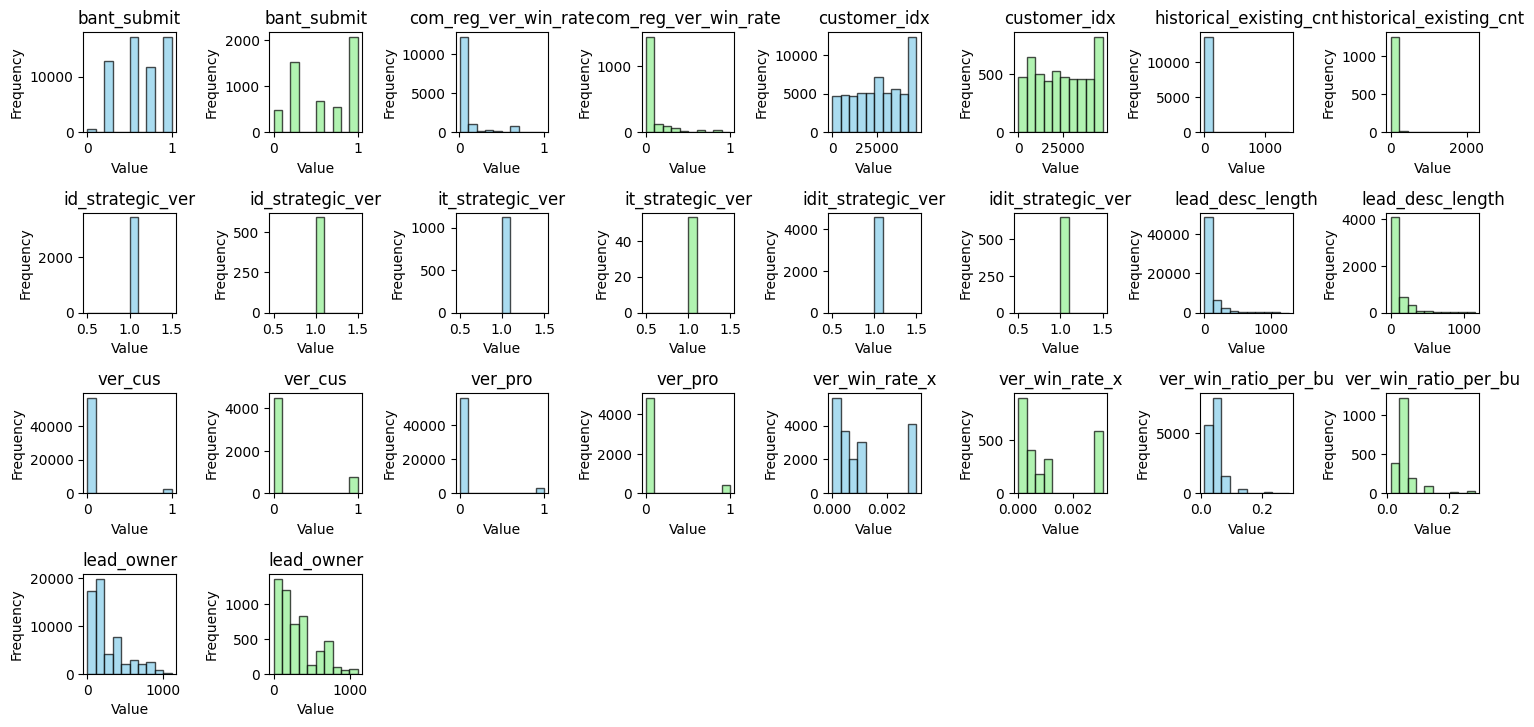

In [ ]:
# 숫자형 데이터만 추출 (id 제외)
numeric_train_df = data.loc[train_index,numeric_columns]
numeric_test_df = data.loc[test_index,numeric_columns]

# 숫자형 데이터의 개수와 히스토그램 subplot 생성
num_rows = 14
num_cols = 8
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 25))

# 각 숫자형 데이터 컬럼에 대해 히스토그램 그리기
for i, col in zip(range(0,len(numeric_train_df)*2,2),numeric_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].hist(numeric_train_df[col], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
    axes[row_idx, col_idx].set_title(col)
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Frequency')

    axes[row_idx, col_idx+1].hist(numeric_test_df[col], bins=10, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[row_idx, col_idx+1].set_title(col)
    axes[row_idx, col_idx+1].set_xlabel('Value')
    axes[row_idx, col_idx+1].set_ylabel('Frequency')

# 빈 subplot 숨기기
for i in range(len(numeric_train_df.columns)*2, num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

#그래프 출력
plt.tight_layout()
plt.show()

([<matplotlib.axis.XTick at 0x7f87d55dfa30>,
 [Text(False, 0, 'False'), Text(True, 0, 'True')])

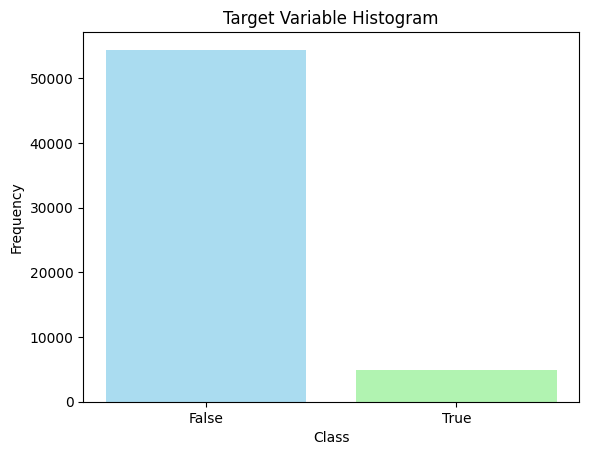

In [ ]:
# 빈도수를 시각화하는 히스토그램 그리기
target_name = list(data.loc[train_index,'is_converted'].value_counts().index)
target_freq = list(data.loc[train_index,'is_converted'].value_counts().values)
plt.bar(target_name, target_freq, color= ['skyblue', 'lightgreen'], alpha=0.7)

# 그래프 제목과 축 레이블 설정
plt.title('Target Variable Histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')

# x축에 라벨링
plt.xticks(target_name, ['False', 'True'])

# 그래프 출력
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


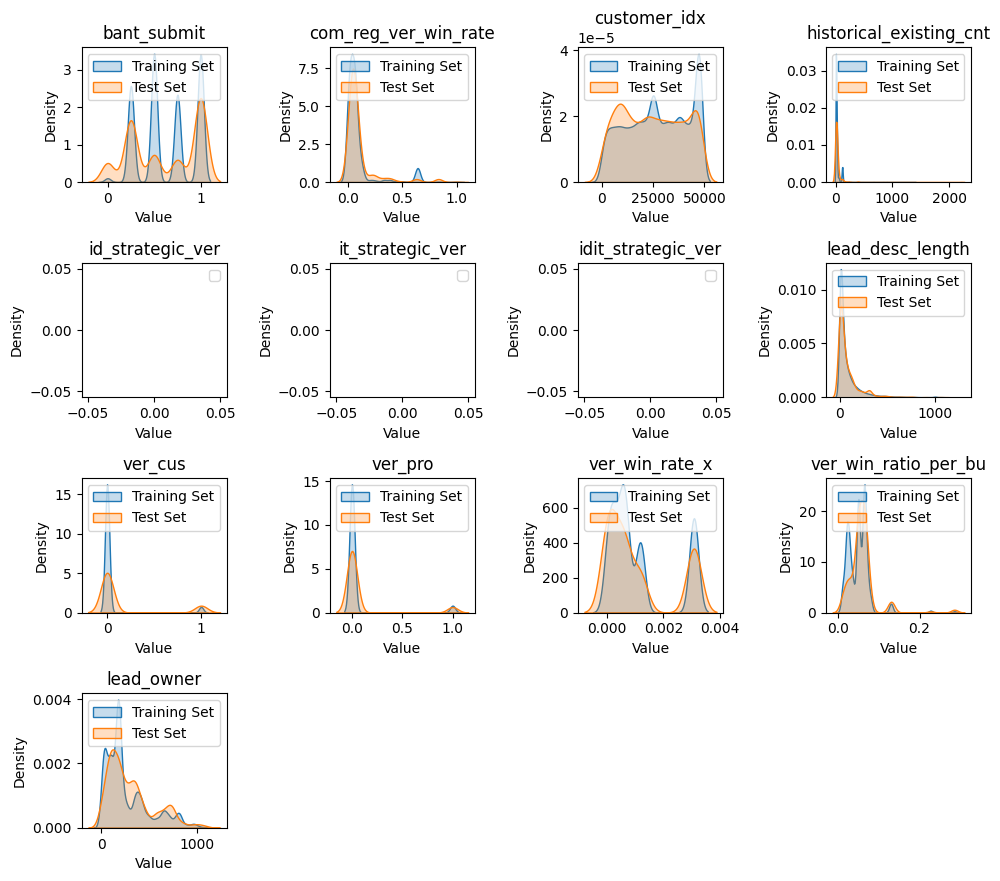

<Figure size 640x480 with 0 Axes>

In [ ]:
# 숫자형 데이터의 개수와 KDE plot subplot 생성
num_rows = 14
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 30), squeeze=False)

# 각 숫자형 데이터 컬럼에 대해 KDE plot 그리기 (inst_id, OC 제외)
for i, col in enumerate(numeric_columns):
    row_idx = i//num_cols
    col_idx = i%num_cols

    sns.kdeplot(numeric_train_df[col], bw_method='silverman', label='Training Set', shade=True, ax=axes[row_idx, col_idx])
    sns.kdeplot(numeric_test_df[col], bw_method='silverman', label='Test Set', shade=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(col)
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Density')
    axes[row_idx, col_idx].legend()

# 빈 subplot 숨기기
for i in range(len(numeric_train_df.columns), num_rows*num_cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    fig.delaxes(axes[row_idx, col_idx])

plt.tight_layout()
plt.show()

# 그래프 출력
plt.tight_layout()
plt.show()

#### ❗ log 변환
- ['historical_existing_cnt', 'lead_desc_length']의 분포가 왼쪽으로 치우짐
- log 변환 후 이상치 시각화

In [ ]:
features = ['historical_existing_cnt', 'lead_desc_length']

# 선택한 열에 로그 변환 적용
df_train[features] = np.log1p(df_train[features])
df_test[features] = np.log1p(df_test[features])

# 숫자형 데이터만 추출 (id 제외)
numeric_train_df = df_train[numeric_columns]
numeric_test_df = df_test[numeric_columns]

## 1-3. 이상치 시각화

- historical existing cnt와 lead desc length에 대해 정규화가 잘 진행된 것을 확인할 수 있음

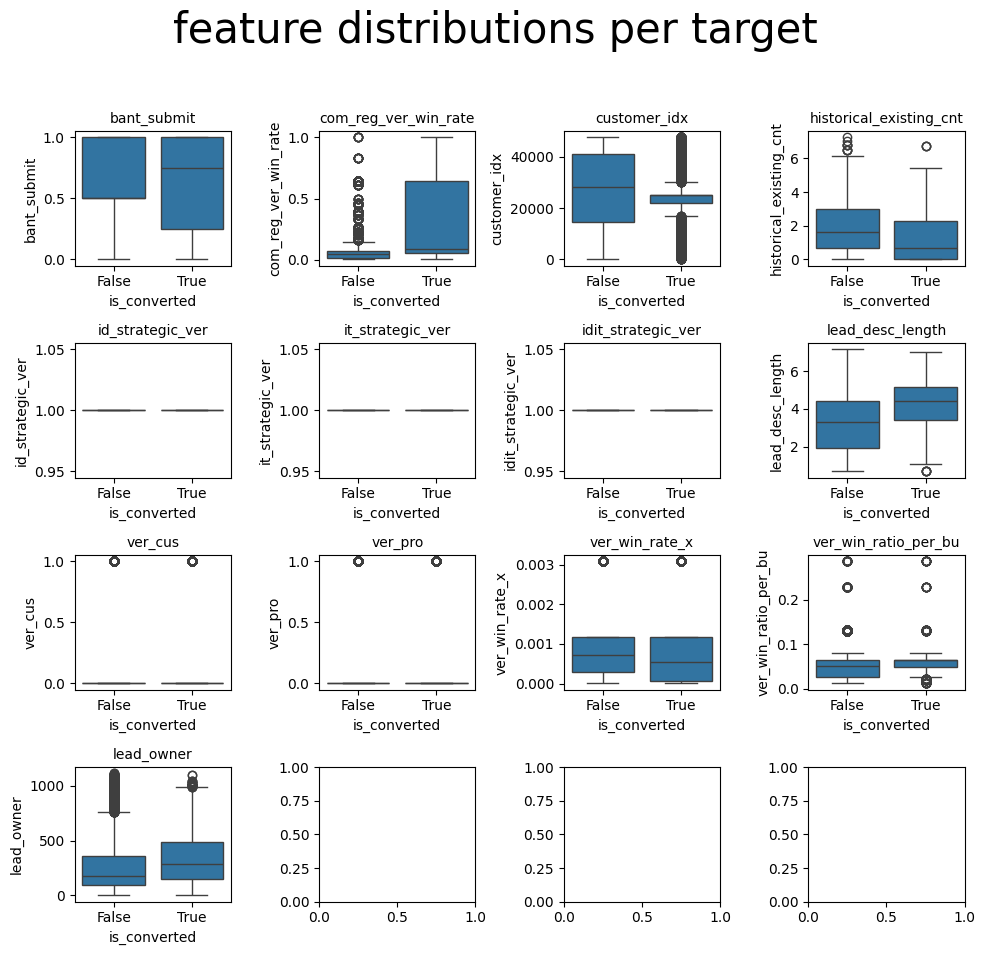

In [ ]:
#박스플롯
numeric_train_df.index = df_train.index
numeric_train_df['is_converted'] = df_train['is_converted']

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle('feature distributions per target', fontsize= 30)
for ax, col in zip(axes.flat, numeric_train_df.columns[:-1]):
    sns.boxplot(x= 'is_converted', y= col, ax=ax, data=numeric_train_df)
    ax.set_title(col, fontsize=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [ ]:
# def outliers_iqr(data):
#     q1, q3 = np.percentile(data, [25, 75])
#     # 넘파이의 값을 퍼센트로 표시해주는 함수

#     iqr = q3 - q1
#     lower_bound = q1 - (iqr * 1.5)
#     upper_bound = q3 + (iqr * 1.5)

#     return np.where((data > upper_bound) | (data < lower_bound))

# 2. ⭕ 데이터 전처리

## 2-1. 학습 데이터 중 결측값이 많은 데이터 삭제

In [ ]:
# 한 행에 Null값 16이상 제거
# 학습하는데에 방해될 것 같음
del_nan_train_df = df_train[df_train.isnull().sum(axis=1) <= 15].copy()

print('기존 학습 데이터 행 개수: %d' %len(df_train))
print('결측값이 많은 데이터를 삭제한 후, 남은 학습 데이터의 행 개수: %d' %len(del_nan_train_df))

# 학습데이터 index 업데이트
train_index = del_nan_train_df.index

기존 학습 데이터 행 개수: 59299
결측값이 많은 데이터를 삭제한 후, 남은 학습 데이터의 행 개수: 59178


## 2-2. 중복 데이터 삭제

In [ ]:
## 데이터의 중복 제거
del_dup_train_df = del_nan_train_df.drop_duplicates()
print('기존 학습 데이터 행 개수: %d' %len(del_nan_train_df))
print('중복값을 제거한 후, 남은 학습 데이터의 행 개수: %d' %len(del_dup_train_df))

# 학습데이터 index 업데이트
train_index = del_dup_train_df.index

기존 학습 데이터 행 개수: 59178
중복값을 제거한 후, 남은 학습 데이터의 행 개수: 55664


## 2-3. 학습에 방해되는 열 drop

In [ ]:
new_train_df = del_dup_train_df.copy()
new_test_df = df_test.copy()

In [ ]:
# 22. ver_cus			특정 Vertical Level 1(사업영역) 이면서 Customer_type(고객 유형)이 소비자 (End-user)인 경우에 대한 가중치
# 23. ver_pro			특정 Vertical Level 1(사업영역) 이면서 특정 Product Category(제품 유형)인 경우에 대한 가중치
## 가중치에 관한 열 중요하지 않다고 판단, drop

new_train_df.drop(['ver_cus','ver_pro','id_strategic_ver','it_strategic_ver','idit_strategic_ver','customer_country.1'], axis=1, inplace=True)
new_test_df.drop(['id','ver_cus','ver_pro','id_strategic_ver','it_strategic_ver','idit_strategic_ver','customer_country.1'], axis=1, inplace=True)

print('기존 학습 데이터의 열 개수: %d' %len(del_dup_train_df.columns))
print('중복된 값을 가지는 열을 삭제한 학습 데이터의 열 개수: %d' %len(new_train_df.columns))
print('')
print('기존 시험 데이터의 열 개수: %d' %len(df_test.columns))
print('중복된 값을 가지는 열을 삭제한 시험 데이터의 열 개수: %d' %len(new_test_df.columns))

기존 학습 데이터의 열 개수: 29
중복된 값을 가지는 열을 삭제한 학습 데이터의 열 개수: 23

기존 시험 데이터의 열 개수: 29
중복된 값을 가지는 열을 삭제한 시험 데이터의 열 개수: 22


## 2-4. 범주형 데이터 cleaning
⬜ : 수정필요 🟦 : 완료

In [ ]:
label_columns = [
    "customer_country",
    "business_area", "business_subarea",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]
numerical_features = [
  'bant_submit',
  'com_reg_ver_win_rate',
  'historical_existing_cnt',
  'lead_desc_length',
  'ver_win_rate_x',
  'ver_win_ratio_per_bu',
]

### 전처리 진행 전 category 상위 범주 만들어주기
- , 로 분류된 데이터들은 integrated solution에 포함

In [ ]:
def is_top_category(text):

  if pd.isna(text):
        return np.nan

  if ',' in text:
    return True
  else:
    return False

top_category = new_train_df['product_category'].apply(is_top_category)

In [ ]:
top_category = top_category.fillna(False)

#### 🟦 특수문자/공백/결측치 처리

In [ ]:
# 데이터 값들 사이에 의미는 같지만 여백이 존재해서 다르게 처리할 수 있음
import string
import re

def remove_punctuation(text):
    if pd.isna(text):
        return np.nan

    text = re.sub('[~_-]', ' ', text)
    text = re.sub('[,&(]', ' ', text)
    text = re.sub('[).]', ' ', text)
    text = text.rstrip()
    text = text.lstrip()
    text = re.sub('\s\s', ' ', text)
    text = re.sub('\s\s', ' ', text)  # 띄어쓰기 연속 제거

    return text

def remove_slash(text):
    if pd.isna(text):
        return np.nan
    return re.sub('/', ' ', text)

In [ ]:
new_train_df[numerical_features] = new_train_df[numerical_features].fillna(0)
new_train_df[numerical_features] = new_train_df[numerical_features].fillna(0)

In [ ]:
for feature in label_columns:
  new_train_df[feature] = new_train_df[feature].str.lower()
  new_train_df[feature] = new_train_df[feature].apply(remove_punctuation)

  new_test_df[feature] = new_test_df[feature].str.lower()
  new_test_df[feature] = new_test_df[feature].apply(remove_punctuation)

### 🟦 영어 외의 언어 >> 영어로

In [ ]:
!pip install googletrans==3.1.0a0

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
from googletrans import Translator
translator = Translator()

def en_dic(df,col):
    unique_value = df[col].unique()
    trans_dic = {}

    for sen in unique_value:
        if sen is np.nan:
            trans_dic[sen] = sen
            continue

        non_alpha_chars = re.sub(r'\W+', '', sen)
        non_alpha_chars = re.search(r'[^a-zA-Z0-9]', non_alpha_chars)

        if non_alpha_chars:
            changed_chars = translator.translate(sen, dest='en').text
            trans_dic[sen] = changed_chars

    return trans_dic

def to_english(df,col):
    # en_dic에 있는 값이면 해당 행 값을 사전의 값으로 교체
    df[col] = df[col].apply(lambda x: dic[x] if x in dic else x)

In [ ]:
need_to_en = ['customer_job' , 'inquiry_type' , 'product_category' , 'product_subcategory' , 'product_modelname']
for n in need_to_en:
    dic = en_dic(new_train_df, n)
    to_english(new_train_df, n)

for n in need_to_en:
    dic = en_dic(new_train_df,n)
    to_english(new_train_df,n)

### 🟦 customer_country
- '/'를 기준으로 country와 city 나누기
- country 결측치 값 city값을 통해 채우기

In [ ]:
# 국가에 대한 소도시 단위 제거, 국가 단위의 데이터가 없는 경우 nan 처리
# 만약 국가 단위만 없고 수도만 있는 경우 수도 이름으로 대체
def process_country(country):
    result = np.nan

    if pd.isna(country):
        return np.nan

    if "/" not in str(country):
        return np.nan

    parts = [x.strip() for x in country.split('/')]  # 모든 요소를 포함하여 분할

    if len(parts) >= 1 and parts[-1] != '':
        return parts[-1]
    else:
        return np.nan

    if '@' in str(result):
        return np.nan

    return result


def process_city(city):

    result = np.nan

    if pd.isna(city):
        return np.nan

    if "/" not in str(city):
        return np.nan

    parts = [x.strip() for x in city.split('/')]  # 모든 요소를 포함하여 분할

    if len(parts) >= 2 and parts[-2] != '':
        return parts[-2]
    else:
        return np.nan

    if '@' in str(result):
        return np.nan

    return result
# 사이트 참고
us_states = [
    "al", "ak", "az", "ar", "ca", "co", "ct", "de", "fl", "ga",
    "hi", "ia", "id", "il", "in", "ks", "ky", "la", "ma", "md",
    "me", "mi", "mn", "ms", "mo", "mt", "nc", "nd", "ne", "nh",
    "nj", "nm", "nv", "ny", "oh", "ok", "or", "pa", "ri", "sc",
    "sd", "tn", "tx", "ut", "vt", "va", "wa", "wi", "wv", "wy",
    "usa", "zip","us", "ohio", "48201", "nevada",
    "hampshire",
    ]

india_states = [
    "odisha", "indore", "kerela", "gujarat", "uttar",
    "gurgaon", "anand", "pune", "lucknow", "bhilwara",
    "chennai", "hyderabad", "telangana", "mumbai","bangalore"]

brazil_states = [
    'br', 'rj'
]

other = [
    'country'
]

def process_unique(country):

  if pd.isna(country):
        return np.nan

  if 'united states' in country:
    return 'us'

  is_states = country.split()

  for state in is_states:
    if state in us_states:
      return 'us'
    elif state in india_states:
      return 'india'
    elif state in brazil_states:
      return 'brazil'
    elif state == 'netherlands':
      return 'nethernads'
    elif state == 'colombia':
      return 'colombia'
    elif state in other:
      return np.nan
  else:
    return country


In [ ]:
print("train set")

new_train_df['country'] = new_train_df['customer_country'].apply(process_country)
print("전처리 전 country nunique:",new_train_df['country'].nunique())

new_train_df['country'] = new_train_df['country'].apply(process_unique)

new_train_df['country'] = new_train_df['country'].replace("a", np.nan)
new_train_df['country'] = new_train_df['country'].replace("u a e", "uae")
new_train_df['country'] = new_train_df['country'].replace("uae dubai", "uae")

print("전처리 후 country nunique:",new_train_df['country'].nunique())
## city
new_train_df['city'] = new_train_df['customer_country'].apply(process_city)
new_train_df['city'] = new_train_df['city'].replace("dubai uae", "dubai")
# ------------ test
print("test set")
new_test_df['customer_country'] = new_test_df['customer_country'].replace("uae dubai", "uae")

new_test_df['country'] = new_test_df['customer_country'].apply(process_country)
print("전처리 전 country nunique:",new_test_df['country'].nunique())

new_train_df['country'] = new_train_df['country'].replace("a", np.nan)
new_train_df['country'] = new_train_df['country'].replace("u a e", "uae")
new_train_df['country'] = new_train_df['country'].replace("uae dubai", "uae")

new_test_df['country'] = new_test_df['country'].apply(process_unique)
print("전처리 후 country nunique:",new_test_df['country'].nunique())

## city
new_test_df['city'] = new_test_df['customer_country'].apply(process_city)
new_test_df['city'] = new_test_df['city'].replace("dubai uae", "dubai")

train set
전처리 전 country nunique: 269
전처리 후 country nunique: 171
test set
전처리 전 country nunique: 94
전처리 후 country nunique: 87


In [ ]:
new_train_df.drop(['customer_country'],axis=1,inplace=True)
new_test_df.drop(['customer_country'],axis=1,inplace=True)

In [ ]:
new_train_df[new_train_df['country'] == 'uae']['is_converted'].value_counts()

is_converted
False    1317
True      213
Name: count, dtype: int64

In [ ]:
new_train_df['country'].unique()

array(['philippines', 'india', 'nigeria', 'saudi arabia', 'singapore',
       'brazil', 'uae', 'south africa', 'us', 'colombia', 'mexico',
       'ghana', 'egypt', 'democratic republic of the congo', 'ethiopia',
       'australia', nan, 'kenya', 'indonesia', 'oman', 'pakistan',
       'united kingdom', 'guatemala', 'panama', 'canada', 'bangladesh',
       'papua new guinea', 'united republic of tanzania', 'qatar',
       'afghanistan', 'chile', 'mozambique', 'turkey', 'türkiye',
       'el salvador', 'togo', 'jordan', 'iraq', 'israel', 'sri lanka',
       'south korea', 'portugal', 'mauritania', 'uruguay', 'peru',
       'germany', 'romania', 'norway', 'jamaica', 'hungary', 'poland',
       'czech', 'spain', 'argentina', 'ecuador', 'senegal', 'hong kong',
       'malaysia', 'japan', 'kuwait', 'ireland', 'albania', 'greece',
       'algeria', 'nicaragua', 'slovenia', 'italy', 'nethernads',
       'dominican republic', 'france', 'uganda', 'iran', 'paraguay',
       'bolivia', 'namibia', 

country 열 결측치값 city 열 이용해서 채우기

In [ ]:
print('도시값으로 결측치 채우기 전 country 결측치 개수')
new_train_df['country'].isnull().sum()

도시값으로 결측치 채우기 전 country 결측치 개수


3938

In [ ]:
# new_train_df[(new_train_df['country'].isna()) & (~new_train_df['city'].isna())]['city'].value_counts().iloc[:50]

In [ ]:
city_to_country = {
    'uae': ['abudhabi','rak','دبي','al ain','uae','dubai', 'abu dhabi', 'sharjah', 'ajman', 'ras al khaimah', 'ابوظبي', 'deira', 'الشارقة', 'alain', 'عجمان', 'fujairah','dubai uae', 'shj', 'ras al khaima'],

    'us': ['new york', 'houston', 'phoenix', 'washington', 'miami', 'los angeles', 'tampa', 'newark', 'chicago', 'san diego', 'indianapolis', 'san antonio', 'salt lake city', 'el paso',
           'austin', 'wichita', 'jacksonville', 'virginia beach', 'san francisco', 'omaha', 'orlando', 'las vegas', 'anaheim', 'philadelphia', 'tucson', 'danville', 'buffalo', 'bellevue',
           'columbus', 'lubbock', 'irvine', 'scottsdale', 'detroit', 'grand rapids', 'fort lauderdale', 'nashville', 'charlotte', 'seattle', 'south bend', 'boca raton', 'new orleans', 'alpharetta',
           'raleigh', 'charleston', 'tulsa', 'greenville', 'spring', 'sacramento', 'providencaies', 'topeka', 'fayetteville', 'atlanta', 'aurora', 'cincinnati', 'hollywood', 'eglin afb', 'montgomery',
           'lincoln', 'irving', 'apo', 'champaign', 'norcross', 'plano', 'federal way', 'silver spring', 'maroa', 'naperville', 'dallas', 'columbia', 'minneapolis', 'boston', 'rancho cucamonga', 'oklahoma city',
           'morristown', 'fort collins', 'baltimore', 'offutt afb', 'saint petersburg', 'santa monica', 'fort worth', 'decatur', 'woodhaven', 'schaumburg', 'mahopac', 'winston', 'birmingham', 'amherst', 'coalgate', 'chesterfield',
           'brooklyn','kansas city','sierra vista', 'bell gardens', 'pigeon forge', 'delray beach', 'augusta', 'cloverdale', 'cypress', 'staten island', 'harrisburg', 'north hollywood', 'colorado springs',
           'olathe', 'elkhart', 'sunnyvale', 'flushing', 'peachtree corners', 'cambridge', 'albuquerque', 'san marcos', 'gaithersburg', 'san jose', 'costa mesa', 'reston', 'malvern', 'dexter', 'jackson',
           'ras al khaima', 'monrovia', 'bridgeport', 'katy', 'long beach', 'bowie', 'lexington', 'lakewood', 'la jolla', 'overland park', 'miami gardens', 'hapeville', 'camden', 'orting', 'richmond'],

    'philippines': ['manila', 'makati', 'quezon city', 'mandaluyong','makati city'],
    'india': ['bangalore', 'mumbai','bengaluru'],
    'saudi arabia': ['riyadh', 'الرياض','riaydh', 'khobar'],
    'oman': ['muscat'],
    'egypt': ['cairo'],
    'kuwait': ['الكويت'],
    'sri lanka': ['colombo 03'],
    'united kingdom': ['liverpool'],
}


In [ ]:
# country 열이 NaN이고 city 열 값이 딕셔너리의 도시에 해당하는 경우에 대해 country 값을 해당 도시에 대응하는 국가로 채움
new_train_df['country'] = new_train_df.apply(lambda row: next((key for key, value in city_to_country.items() if pd.isna(row['country']) and row['city'] in value), row['country']), axis=1)
new_test_df['country'] = new_test_df.apply(lambda row: next((key for key, value in city_to_country.items() if pd.isna(row['country']) and row['city'] in value), row['country']), axis=1)

In [ ]:
print('도시값으로 결측치 채운 후 country 결측치 개수')
new_train_df['country'].isnull().sum()

도시값으로 결측치 채운 후 country 결측치 개수


3386

In [ ]:
new_train_df[['country', 'city']] = new_train_df[['country', 'city']].fillna('other')
new_test_df[['country', 'city']] = new_test_df[['country', 'city']].fillna('other')

In [ ]:
label_columns = [
    "country","city",
    "business_area", "business_subarea",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

### 🟦 response_corporate
- 앞의 문자열 공통 'lge' 제거


In [ ]:
new_train_df['response_corporate'] = new_train_df['response_corporate'].str.replace("lge", "")
new_test_df['response_corporate'] = new_test_df['response_corporate'].str.replace("lge", "")

In [ ]:
new_test_df['response_corporate']

0       sp
1       us
2       gf
3       us
4       sp
        ..
5266    sp
5267    us
5268    sp
5269    dg
5270    il
Name: response_corporate, Length: 5271, dtype: object

### 🟦  inquiry_type

In [ ]:
# Other, Others, Etc., ETC., Not specified  >> 똑같은 데이터로 처리 : other
# 결측치 처리 >> other
def process_etc(data):
    if data in [
        'other', 'others', 'etc.', 'not specified', 'none',
        'Other Stores', 'Others', 'nan', 'etc', 'no longer available','not applicable','no influence',
        ]:
        return np.nan
    else:
        return data

def process_inquiry(df):
  df['inquiry_type'].replace({
      'purchase' : 'quotation or purchase consultation',
      'quotation' : 'quotation or purchase consultation',
      'purchase or quotation' : 'quotation or purchase consultation',
      'hola me pueden cotizar 19 pantallas interactivas de 100 pulgadas entregadas en guayaquil ecuador' : 'quotation or purchase consultation',
      'Please give me a quote for the body temperature measurement product, thank you' : 'quotation or purchase consultation',
      'probeam precio' : 'quotation or purchase consultation',
      'I request support to make a quote for the devices they offer in the one quick solution' : 'quotation or purchase consultation',
      'please give me a quote for the body temperature measurement product, thank you' : 'quotation or purchase consultation',
      'i request support to make a quote for the devices they offer in the one quick solution:' : 'quotation or purchase consultation',
      'i need to consult prices and solutions from lg' : 'quotation or purchase consultation',

      'usage_or_technical_consultation' : 'usage or technical consultation',
      'I need to consult prices and solutions from LG' : 'usage or technical consultation',

      'technical support' : 'technical consultation',
      'technical' : 'technical consultation',

      'one quick:flex' : 'product information',
      'aio' : 'product information',
      'i want to know the details about it' : 'product information',
      'hospital tv' : 'product information',
      'educational equipments' : 'product information',
      'tv interactive' : 'product information',
      'digital platform' : 'product information',
      'high inch 86   98 or 110' : 'product information',
      'display textbook and photos' : 'product information',
      'display product' : 'product information',
      'window facing product' : 'product information',
      'hotel tv products' : 'product information',
      'pantallas interactivas para clinicas' : 'product information',
      'toi muon tim hieu thong tin ky thuat gia ca cua sp de su dung' : 'product information',
      'led signage' : 'product information',
      'for school' : 'product information',
      'video wall' : 'product information',
      'first info and pricing' : 'product information',
      'idb' : 'product information',
      'vrf' : 'product information',
      'standalone' : 'product information',
      'high inch 86 / 98 or 110' : 'product information',
      'i am looking for this lg magnit micro led product for ecuador for a 138-inch client with sea shipping' : 'product information',
      'i need a medical monitor for conventional radiography and tomography' : 'product information',


      'evento sdelestero' : 'event inquiry',

      'select id needs' : 'other',
      'needs' : 'other',
      'teach' : 'other',
      'event inquiry' : 'other',
      'media inquiry' : 'other',
      'historical integrator of george v' : 'other',

      'not specified' : 'other',
      'nan' : 'other',
      'no influence' : 'other',
      'not applicable' : 'other',
      'no longer available' : 'other'
      }, inplace = True)

# 동일 범주형 데이터에 대한 대소문자 구별 없애기
new_train_df['inquiry_type'] = new_train_df['inquiry_type'].str.lower()
new_train_df['inquiry_type'] = new_train_df['inquiry_type'].apply(process_etc)


new_test_df['inquiry_type'] = new_test_df['inquiry_type'].str.lower()
new_test_df['inquiry_type'] = new_test_df['inquiry_type'].apply(process_etc)

# 학습 데이터프레임 처리
process_inquiry(new_train_df)

# 테스트 데이터프레임 처리
process_inquiry(new_test_df)

In [ ]:
new_train_df['inquiry_type'].fillna('other', inplace=True)
new_test_df['inquiry_type'].fillna('other', inplace=True)

In [ ]:
for x in new_train_df['inquiry_type'].unique():
    print(x, new_train_df['inquiry_type'].value_counts()[x])

quotation or purchase consultation 40250
product information 1132
other 2156
usage or technical consultation 1118
trainings 376
services 361
sales inquiry 8846
technical consultation 535
request for partnership 273
sales 100
request a demo 174
request for distributorship 67
request for quotation or purchase 221
request for technical consulting 37
customer suggestions 12
oem/odm request 5
event inquiry 1


In [ ]:
for x in new_test_df['inquiry_type'].unique():
    print(x, new_test_df['inquiry_type'].value_counts()[x])

other 1416
quotation or purchase consultation 3465
product information 68
technical consultation 135
request for partnership 63
usage or technical consultation 52
services 34
customer suggestions 4
request a demo 9
trainings 21
oem/odm request 3
request for distributorship 1


### 🟦 customer_type
- 사이트 참고하여 sub type으로 작성된 경우 상위 type으로 변경해주는 작업 진행

In [ ]:
new_train_df['customer_type'] = new_train_df['customer_type'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)
new_test_df['customer_type'] = new_test_df['customer_type'].apply(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

new_train_df['customer_type'].replace('enduser', 'endcustomer',inplace=True)
new_train_df['customer_type'].replace('commercialenduser', 'endcustomer',inplace=True)
new_train_df['customer_type'] = new_train_df['customer_type'].apply(process_etc)

new_test_df['customer_type'].replace('enduser', 'endcustomer',inplace=True)
new_test_df['customer_type'].replace('commercialenduser', 'endcustomer',inplace=True)
new_test_df['customer_type'] = new_test_df['customer_type'].apply(process_etc)

In [ ]:
new_train_df['customer_type'].fillna('other', inplace=True)
new_test_df['customer_type'].fillna('other', inplace=True)

In [ ]:
def process_type_mapping(df):
  # 사이트 참고하여 딕셔너리 구성
  customer_type_mapping =  {
    'endcustomer' : ['construction company', 'owner', 'homeowner', 'developer', 'medical/healthcare facility',
                      'goverment/public sector', 'corporate', 'education', 'retail', 'fitness', 'manager/director', 'administrator'],

    'channelpartner' : ['agent','distributor','reseller','nsp','national reseller','regional reseller', 'si', 'pro', 'var'],

    'specifier/influencer' : ['architect', 'consultant', 'contractor', 'technical/design firm', 'region builder', 'installer', 'ad&contents provider', 'applied rep'],

    'solutionecopartner' : ['cms/webos/isv', 'mount/metal fabrication','meeting solution', 'control/processor', 'external compute'],

    'other' : ['hvacengineer', 'engineer', 'technician', 'systemintegrator'] # 분류를 어떻게 해야 할지 모르는 train unique한 값들
    }
  for new_type, keywords in customer_type_mapping.items():
      df.loc[df['customer_type'].str.contains('|'.join(keywords), case=False), 'customer_type'] = new_type

new_train_df['customer_type'] = new_train_df['customer_type'].astype(str)
new_test_df['customer_type'] = new_test_df['customer_type'].astype(str)

# 학습 데이터프레임 처리
process_type_mapping(new_train_df)

# 테스트 데이터프레임 처리
process_type_mapping(new_test_df)

In [ ]:
 new_train_df['customer_type'].value_counts()

customer_type
other                   41314
endcustomer             10167
specifier/influencer     2433
channelpartner           1306
servicepartner            316
solutionecopartner        128
Name: count, dtype: int64

In [ ]:
new_test_df['customer_type'].value_counts()

customer_type
endcustomer             2455
other                   1457
specifier/influencer     788
channelpartner           327
solutionecopartner       146
servicepartner            98
Name: count, dtype: int64

### 🟦 customer_position
- 하드코딩으로 분류

In [ ]:
# 공통 함수 정의
def process_position(df):
    df['customer_position'].replace({
        'founder' : 'ceo founder',
        'ceo/fundador': 'ceo founder',
        'ceo/founder' : 'ceo founder',
        'co founder': 'ceo founder',
        'mindenes': 'ceo founder',
        'genel müdür': 'ceo founder',
        'leadership/executive office/owner': 'ceo founder',
        'the big boss': 'ceo founder',
        'entrepreneur' : 'ceo founder',
        'entrepreneurship' :'ceo founder',
        'business development': 'ceo founder',
        'chairman': 'ceo founder',
        'president' : 'ceo founder',

        'decision influencer': 'decision-influencer',
        'decision maker': 'decision-influencer',

        'vp': 'vice president',
        'vicepresident':'vice president',
        'visepresident' : 'vice president',
        'gerente': 'vice president',

        'architecture/consult' : 'consultant',
        'architect/consultant': 'consultant',
        'consulting': 'consultant',

        'asst prof' : 'assistant professor',
        'prof' : 'professor',
        'education' : 'professor',
        'educator' : 'professor',
        'education professional': 'professor',
        'főorvos': 'professor',
        'english trainer for ielts toefl pte gre sat exams' : 'professor',
        'career coach' : 'professor',
        'hon dean' : 'professor',
        'academic specialist' : 'professor',

        'business partner': 'partner',
        'commercial consultant': 'partner',

        'c levelexecutive': 'c level executive',
        'chief executive officer': 'c level executive',

        'entrylevel': 'entry level',

        'lider de desarrollo': 'manager',
        'administrative' : 'manager',
        'market intelligence/research': 'manager',
        'operations': 'manager',

        'business development/sales': 'associate/analyst',

        'principal at oxford integrated pu science college': 'director',
        'professional trainer': 'director',

        'unpaid': 'intern',

        'exhibitiontv': 'exhibition',

        'proprietário a': 'homeowner',

        'this is a consume display requirement for home purpose':'customer',
        'end user': 'customer',
        'commercial end user' : 'customer',

        'surgery professional': 'hospital',
        'tierarzt' : 'hospital',
        'pathologist' : 'hospital',
        'radiology professional' : 'hospital',

        'medical imaging specialist': 'manufacturer',
        'business development/sales': 'manufacturer',
        'carge': 'manufacturer',

        'research': 'software/solution provider',
        'software /solution provider':'software/solution provider',


        'technical' : 'technician',
        'técnico' : 'technician',
    }, inplace=True)

    df['customer_position'] = df['customer_position'].str.lower()
    df.loc[df['customer_position'].str.contains('teacher'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('professor'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('lecturer'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('pgt'), 'customer_position'] = 'professor'
    df.loc[df['customer_position'].str.contains('faculty'), 'customer_position'] = 'professor'

    df.loc[df['customer_position'].str.contains('management'), 'customer_position'] = 'manager'

    df.loc[df['customer_position'].str.contains('director'), 'customer_position'] = 'director'

    df.loc[df['customer_position'].str.contains('association'), 'customer_position'] = 'associate/analyst'

    df.loc[df['customer_position'].str.contains('sales'), 'customer_position'] = 'manufacturer'
    df.loc[df['customer_position'].str.contains('manufacturer'), 'customer_position'] = 'manufacturer'

    df['customer_position'] = df['customer_position'].apply(process_etc)

new_train_df['customer_position'] = new_train_df['customer_position'].astype(str)
new_test_df['customer_position'] = new_test_df['customer_position'].astype(str)
# 학습 데이터프레임 처리
process_position(new_train_df)

# 테스트 데이터프레임 처리
process_position(new_test_df)

In [ ]:
new_train_df['customer_position'].fillna('other', inplace=True)
new_test_df['customer_position'].fillna('other', inplace =True)

In [ ]:
for x in new_train_df['customer_position'].unique():
    print(x, new_train_df['customer_position'].value_counts()[x])

entry level 2126
ceo founder 7766
partner 2480
manager 7906
vice president 507
associate/analyst 2507
c level executive 821
other 24567
director 4738
intern 434
trainee 820
customer 433
consultant 27
professor 43
installer 59
homeowner 22
employee 14
bulgaria 7
decision-influencer 26
technician 2
exhibition 4
hospital 203
government 29
manufacturer 40
software/solution provider 26
system integrator 21
distributor 1
engineering 8
cargo 27


In [ ]:
for x in new_test_df['customer_position'].unique():
    print(x, new_test_df['customer_position'].value_counts()[x])

other 2621
manager 726
associate/analyst 279
director 343
entry level 225
ceo founder 594
partner 224
c level executive 85
trainee 49
vice president 54
intern 60
professor 9
customer 2


### 🟦 customer_job (진행중)
- sentence transformer 적용

In [ ]:
!pip install -U sentence-transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
# https://www.lg.com/global/business/inquiry-to-buy
# 사이트 내 job function 참고
customer_job_list = [
  'accounting', 'administrative', 'arts and design', 'business development',
  'community and social services', 'consulting', 'curation', 'education',
  'engineering', 'entrepreneurship', 'finance', 'healthcare services', 'human resources',
  'information technology', 'legal', 'marketing', 'media and communication',
  'military and protective services', 'operations', 'product management',
  'program and project management', 'purchasing', 'quality assurance',
  'real estate', 'research', 'sales', 'support', 'other'
]

# vertrieb, sonstiges 같은 번역이 안된 단어는 처리가 안됨 -> 💥사전에 번역하는 코드 더 추가해야함💥
customer_job_replace_words = {
    'sonstiges' : 'other',
    'otro' : 'other',
    'vertrieb' : 'sales'
}

In [ ]:
new_train_df['customer_job'] = new_train_df['customer_job'].apply(process_etc)
new_train_df['customer_job'] = new_train_df['customer_job'].fillna('other')

new_test_df['customer_job'] = new_test_df['customer_job'].apply(process_etc)
new_test_df['customer_job'] = new_test_df['customer_job'].fillna('other')

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
job_embeddings = model.encode(customer_job_list)

In [ ]:
# 테스트 해보기
from sklearn.metrics.pairwise import cosine_similarity

test = 'hr'
test_vector = model.encode([test])

# 새로운 직업과 기존 직업들 간의 코사인 유사도 계산
similarities = cosine_similarity(test_vector, job_embeddings)

# 가장 유사도가 높은 직업 카테고리 찾기
most_similar_index = np.argmax(similarities)
most_similar_job = customer_job_list[most_similar_index]
most_similar_job, np.max(similarities)

('human resources', 0.7098565)

In [ ]:
def preprocess_job(job):
  if isinstance(job, str):
    if job in customer_job_list:
      return job
    else:
      job_vector = model.encode([job])
      similarities = cosine_similarity(job_vector, job_embeddings)

      if np.max(similarities) < 0.4:
        return 'other'
      else:
        most_similar_index = np.argmax(similarities)
        most_similar_job = customer_job_list[most_similar_index]
        return most_similar_job
  else:
    return job

In [ ]:
# 1~2분 정도 소요
new_train_df['customer_job'] = new_train_df['customer_job'].apply(preprocess_job)
new_test_df['customer_job'] = new_test_df['customer_job'].apply(preprocess_job)

In [ ]:
new_train_df['customer_job'].value_counts()

customer_job
other                               22666
engineering                          6083
administrative                       3494
sales                                2407
education                            2272
purchasing                           2027
information technology               1961
operations                           1890
arts and design                      1851
business development                 1747
consulting                           1342
entrepreneurship                     1173
marketing                            1124
healthcare services                  1114
program and project management       1032
media and communication               700
product management                    577
finance                               460
accounting                            394
support                               350
real estate                           294
legal                                 149
community and social services         140
research             

In [ ]:
new_test_df['customer_job'].value_counts()

customer_job
other                               1954
engineering                          728
education                            409
administrative                       307
information technology               231
operations                           195
purchasing                           180
consulting                           166
sales                                164
business development                 164
entrepreneurship                     119
arts and design                      104
program and project management        96
marketing                             94
media and communication               49
healthcare services                   49
support                               47
finance                               42
product management                    36
accounting                            34
real estate                           26
community and social services         22
legal                                 17
human resources                       14
res

### ⬜ product category (진행중)

In [ ]:
def process_product_category(category):

    if pd.isna(category):
        return np.nan

    # 카테고리 치환 사전
    category_mapping =  {
        'signage': ['awzm', 'lg led bloc', 'gsca', 'gscd', 'lsca039'],
        'tv': ['awz', 'bwz', 'tv signage', 'digital signage or commercial tvs', 'htv', 'tv 60',
               'ctv','tv55', 'tv43pol', 'ur640', 'ur640s', '50uq801c0sb.bwz',
               'uh', 'vl', 'high inch 86 / 98 or 110', '43us660h', 'hoteleria us670h','tv 55'],
        'system ac': ['cac', 'sac', 'vrfcentralairconditioner', 'aire acondicionado residencial', 'systemac', 'onorseveralreversibleac', 'ar condicionado residencial'],
        'vrf': ['vrf', 'variablerefrigerantflow(drv)systems'],
        'video wall': ['wall', '49vl5g', 'vm', '55svh7f a'],
        'procentric': ['centric'],
        'monitor': ['pol', '28mq780', '55tc3d'],
        'multiv': ['multiv'],
        'display': ['display'],
        'audio': ['audio'],
        'aio': ['aio'],
        'led': ['led', 'gscd046', 'laec'],
        'chiller': ['chill'],
        'one quick': ['one', 'quick'],
        'washing machine': ['washing'],
        'multi split': ['multi', 'split'],
        'single split': ['single', 'split'],
        'projector': ['bu50nst'],
        'board': ['board', 'tr3'],
        'airsolution': ['airsolution', 'acrumah'],
        'other': ['etc.','Other']
    }

    # 카테고리 치환
    for key, values in category_mapping.items():
        if any(value in category for value in values):
            return key

    return category

new_train_df['product_category'] = new_train_df['product_category'].apply(process_etc)
new_test_df['product_category'] = new_test_df['product_category'].apply(process_etc)

new_train_df['product_category'] = new_train_df['product_category'].apply(process_product_category)
new_test_df['product_category'] = new_test_df['product_category'].apply(process_product_category)

In [ ]:
new_train_df['product_category'].value_counts().iloc[:40]

product_category
board                                6104
multi split                          5405
vrf                                  5367
led                                  3165
video wall                           2124
interactive signage                  1829
one quick                            1548
rac                                  1427
display                              1100
hotel tv                             1085
chiller                              1039
standard signage                      972
monitor                               749
heating                               639
high brightness signage               458
ventilation                           391
teto ou cassete inverter              298
tv                                    282
system ac                             243
high brightness                       219
control                               197
software solution                     186
accessories                           173
special signage  

In [ ]:
new_train_df['product_category'].isna().sum()

19060

#### ❗product category 결측치 채우기
- sub category , category는 상속관계
- 만약 sub category가 같은 값을 가지는 데 category가 다른 값을 가지는 경우 통일 시켜 **결측치 채우기**

In [ ]:
# 최빈값으로 채우는 데에 방해되는 요소들 replace
new_train_df['product_subcategory'].replace("diagnostic monitors\u200b","diagnostic monitors", inplace=True)
new_train_df['product_subcategory'].replace("all medical displays","all medical display", inplace=True)

In [ ]:
from collections import Counter

# category가 null이고 subcategory가 null이 아닌 행을 필터링 후 리스트에 담기
missing_category = new_train_df[(new_train_df['product_category'].isna()) & (~new_train_df['product_subcategory'].isna())]
sub_list = missing_category['product_subcategory'].unique().tolist()

# 리스트에 있는 값들 중 category가 null값이 아닌 값들
filtered_rows = new_train_df[(new_train_df['product_subcategory'].isin(sub_list)) & (~new_train_df['product_category'].isna())][['product_category','product_subcategory']]

# 딕셔너리에 매칭
matching_dict = {}


# 각 subcategory에 대해 가장 빈도가 높은 category 값을 찾기
for subcategory in sub_list:
    category_counts = Counter(filtered_rows[filtered_rows['product_subcategory'] == subcategory]['product_category'])
    most_common_category = category_counts.most_common(1)
    if most_common_category:
        matching_dict[subcategory] = most_common_category[0][0]
matching_dict

{'oled pro monitor': 'led',
 'diagnostic monitors': 'display',
 'thin clients': 'cloud device',
 'uhd 4k monitors': 'monitor pc',
 'digital x ray detectors': 'display',
 'zero clients': 'cloud device',
 'all medical display': 'display',
 'clinical review monitors': 'display',
 'ips monitors': 'monitor pc',
 'surgical monitors': 'display',
 'other': 'display',
 'all monitors pcs': 'monitor pc',
 'laptops': 'monitor pc',
 'probeam': 'projector',
 'all cloud devices': 'cloud device',
 'all projectors': 'projector',
 'others': 'monitor',
 'ultrawide™ monitors': 'monitor',
 'tv monitors': 'monitor pc',
 'interactive digital board': 'interactive signage'}

In [ ]:
for index, row in new_train_df[(new_train_df['product_subcategory'].isin(sub_list)) & (new_train_df['product_category'].isna())].iterrows():
    if row['product_subcategory'] in matching_dict:
        new_train_df.at[index, 'product_category'] = matching_dict[row['product_subcategory']]

In [ ]:
# new_train_df[new_train_df['product_subcategory'] == 'oled pro monitor'][['product_category','product_subcategory']]

In [ ]:
new_train_df['product_category'].isna().sum()

18779

In [ ]:
# model name으로도 똑같이 진행

missing_category = new_train_df[(new_train_df['product_category'].isna()) & (~new_train_df['product_modelname'].isna())]
sub_list = missing_category['product_modelname'].unique().tolist()

# 리스트에 있는 값들 중 category가 null값이 아닌 값들
filtered_rows = new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (~new_train_df['product_category'].isna())][['product_category','product_modelname']]

# 딕셔너리에 매칭
matching_dict = {}

for subcategory in sub_list:
    category_counts = Counter(filtered_rows[filtered_rows['product_modelname'] == subcategory]['product_category'])
    most_common_category = category_counts.most_common(1)
    if most_common_category:
        matching_dict[subcategory] = most_common_category[0][0]
matching_dict

{'lg supersign cms': 'board',
 '55ct5wj 43ht3wj sc 00da': 'procentric',
 'sc 00da': 'one quick',
 '43ht3wj': 'one quick',
 '55ct5wj': 'one quick',
 'ultrafine ergo 32un880': 'display',
 'ergo dual 27qp88d': 'cloud device',
 '32un880': 'monitor',
 '31hn713d': 'display',
 '21hq513d': 'display',
 'ultrawide ergo 34wn780': 'display',
 '28mq780': 'display'}

In [ ]:
for index, row in new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (new_train_df['product_category'].isna())].iterrows():
    if row['product_modelname'] in matching_dict:
        new_train_df.at[index, 'product_category'] = matching_dict[row['product_modelname']]

In [ ]:
new_train_df['product_category'].isna().sum()

17425

In [ ]:
new_train_df['product_category'].nunique()

161

In [ ]:
new_train_df['product_category'] = new_train_df['product_category'].fillna('other')
new_test_df['product_category'] = new_test_df['product_category'].fillna('other')

#### product category 상위범주 만들기

In [ ]:
product_category_dict = {
    # B2B Product Inquiry
    'commmercial display' : ['commercial display', 'digital signage', 'commercial tv',
                             'oled signage', 'led signage', 'video wall signage', 'interactive signage',
                             'high brightness signage','special signage', 'standard signage', 'hotel tv',
                             'hospital tv', 'accessories', 'software solution', 'signage care solution',
                             'webos', 'pro:centric', 'one:quick series'],

    'it products' : ['monitor', 'laptop', 'projector', 'cloud device', 'medical display'],

    'hvac/ess' : ['control', 'ventilation', 'vrf', 'multi split', 'single split', 'chiller', 'heating'],

    'commmercial laundry' : ['titan','giant'],

    'compressor&motor' : ['compressor', 'reciprocating compressor', 'rotary compressor', 'scroll compressor', 'motor'],

    'robot' : ['lg cloi carrybot', 'lg cloi servebot', 'lg cloi servebot', 'lg cloi guidebot'],

    'advanced materials' : ['antimicrobial', 'porcelain enamel', 'specialty glass'],

    # Integrated Solution Inquiry
    'integrated solutions' : ['integrated solutions',
                              'monitor', 'signage', 'commercial tv', 'ess', 'monior monitor tv',
                              'pc', 'projector', 'robot', 'system ac', 'ems', 'rac', 'chiller', 'tv',
                              'refrigerator', 'washing machine', 'aircare', 'vacuum cleaner', 'styler',
                              'dryer', 'built in cooking', 'home beauty', 'water care', 'audio video']
    # === monitor, robot, chiller이 B2B Product Inquiry과 중복 === 여러개 선택해서 그런듯
    }

product_category_replace_words = {
    'robots' : 'robot',
    'lg one:quick series' : 'one:quick series',
    'lg one:quick' : 'one:quick series',
    'aio | one quick' : 'one:quick series',
    'onequick series' : 'one:quick series',
    'one quick:flex' : 'one:quick series',
    'one:quick flex' : 'one:quick series',
    'one:quick' : 'one:quick series',
    'standard' : 'standard signage',
    'interactive digital board' : 'interactive signage',
    'video wall' : 'video wall signage',
    'high brightness' : 'high brightness signage',

    'multi v 5 air' : 'vrf',
    'multi v' : 'vrf',
    'all lg vrf systems' : 'vrf',
    'kimatyzacja vrf' : 'vrf',

    'klimatyzacja multi split' : 'multi split',

    'teto ou cassete inverter' : 'single split',
    'ar condicionado residencial' : 'single split',
    'residential air conditioner' : 'single split',

    'medical displays' : 'medical display',
    'surgical monitor' : 'monitor',
    'medical monitors' : 'monitor',
    'medical monitor' : 'monitor',

    'uhd signage' : 'digital signage',
    'ur640' : 'digital signage',
    'ur640s' : 'digital signage'
  }

In [ ]:
new_train_df['product_category'][top_category] = 'integrated solutions'

In [ ]:
product_category_list = []

for category in list(product_category_dict.keys()):
  product_category_list = product_category_list + product_category_dict[category]

In [ ]:
new_train_df['product_category'] = new_train_df['product_category'].replace(product_category_replace_words)
new_test_df['product_category'] = new_test_df['product_category'].replace(product_category_replace_words)

In [ ]:
def process_product_category(text):
  result = text

  if pd.isna(text):
    return 'other'

  for new_category, keywords in product_category_dict.items():
    if text == new_category or text in keywords:
      return new_category

  return 'other'

In [ ]:
# product_category 상위 범주
new_train_df['product_category_0'] = new_train_df['product_category'].apply(process_product_category)
new_test_df['product_category_0'] = new_test_df['product_category'].apply(process_product_category)

In [ ]:
new_train_df['product_category_0'].value_counts()

product_category_0
other                   31241
hvac/ess                13263
commmercial display      7602
integrated solutions     2385
it products              1166
robot                       6
compressor&motor            1
Name: count, dtype: int64

In [ ]:
new_test_df['product_category_0'].value_counts()

product_category_0
other                   2597
hvac/ess                1659
commmercial display      910
it products              101
integrated solutions       4
Name: count, dtype: int64

### ⬜ ❗ product_subcategory

In [ ]:
new_train_df['product_subcategory'].isna().sum()

46658

In [ ]:
# model name으로 sub category 채우기

missing_category = new_train_df[(new_train_df['product_subcategory'].isna()) & (~new_train_df['product_modelname'].isna())]
sub_list = missing_category['product_modelname'].unique().tolist()

# 리스트에 있는 값들 중 category가 null값이 아닌 값들
filtered_rows = new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (~new_train_df['product_subcategory'].isna())][['product_subcategory','product_modelname']]

# 딕셔너리에 매칭
matching_dict = {}

for subcategory in sub_list:
    category_counts = Counter(filtered_rows[filtered_rows['product_modelname'] == subcategory]['product_subcategory'])
    most_common_category = category_counts.most_common(1)
    if most_common_category:
        matching_dict[subcategory] = most_common_category[0][0]

matching_dict

{'sc 00da': 'one:quick share',
 '43ht3wj': 'one:quick flex',
 '55ct5wj': 'one:quick works',
 'ultrafine ergo 32un880': 'all medical display',
 '32un880': 'oled monitors',
 '31hn713d': 'diagnostic monitors',
 '21hq513d': 'all medical display',
 '28mq780': 'diagnostic monitors',
 'ltak140': 'transparent led film',
 'lad033f': 'led cinema',
 '75xs4g': 'window facing display',
 '43us660h': 'us660h series',
 '49vl5g m': '49" 500 nits fhd slim bezel video wall',
 'idb': 'idb',
 'ultrawide ergo 34wn780': 'diagnostic monitors',
 '32hl512d': 'diagnostic monitors'}

In [ ]:
for index, row in new_train_df[(new_train_df['product_modelname'].isin(sub_list)) & (new_train_df['product_subcategory'].isna())].iterrows():
    if row['product_modelname'] in matching_dict:
        new_train_df.at[index, 'product_subcategory'] = matching_dict[row['product_modelname']]

In [ ]:
new_train_df['product_subcategory'].isna().sum()

45465

In [ ]:
new_train_df['product_subcategory'].fillna('other', inplace=True)
new_test_df['product_subcategory'].fillna('other', inplace=True)
new_train_df['product_modelname'].fillna('other', inplace=True)
new_test_df['product_modelname'].fillna('other', inplace=True)

### 🟦 business_area, business_subarea
- business area는 다른데 business_subarea가 같은 경우를 다르게 처리하기 위해 열을 묶어서 하나의 열로 만들어주기

In [ ]:
new_train_df['business_subarea'] = new_train_df['business_subarea'].apply(process_etc)
new_train_df['business_area'] = new_train_df['business_area'].apply(process_etc)

new_train_df['business'] = new_train_df['business_subarea'].str.cat(new_train_df['business_area'], sep=' / ')

##
new_test_df['business_subarea'] = new_test_df['business_subarea'].apply(process_etc)
new_test_df['business_area'] = new_test_df['business_area'].apply(process_etc)

new_test_df['business'] = new_test_df['business_subarea'].str.cat(new_test_df['business_area'], sep=' / ')

In [ ]:
new_train_df['business_area'].fillna('other', inplace=True)
new_train_df['business'].fillna('other', inplace=True)

In [ ]:
for x in new_train_df['business_area'].unique():
    print(x, new_train_df['business_area'].value_counts()[x])

corporate / office 3989
other 37877
education 1682
hotel accommodation 1960
hospital health care 1023
special purpose 1873
residential home 1786
government department 635
retail 2924
factory 1013
power plant / renewable energy 108
transportation 292
public facility 502


In [ ]:
for x in new_train_df['business'].unique():
    print(x, new_train_df['business'].value_counts()[x])

engineering / corporate / office 173
advertising / corporate / office 118
construction / corporate / office 182
it/software / corporate / office 125
other 52069
manufacturing / corporate / office 40
energy / corporate / office 24
developer/property / corporate / office 27
entertainment / corporate / office 33
agriculture / corporate / office 13
pharmaceutical / corporate / office 7
banking / corporate / office 16
consulting / corporate / office 46
healthcare / corporate / office 24
finance / corporate / office 30
broadcasting media / corporate / office 38
distribution center / corporate / office 16
law firm / corporate / office 16
logistics / corporate / office 14
telecommunication / corporate / office 37
aerospace / corporate / office 5
network/cabling / corporate / office 6
insurance / corporate / office 5
institute academy / education 102
hotel / hotel accommodation 35
k12 kindergarten schools / education 125
hospital / hospital health care 245
mixed use multi complex / special purp

### 🟦 business_unit

In [ ]:
for x in new_train_df['business_unit'].unique():
    print(x, new_train_df['business_unit'].value_counts()[x])

as 22623
id 24777
it 7976
solution 287
cm 1


In [ ]:
for x in new_train_df['business_unit'].unique():
    print(x, new_train_df['business_unit'].value_counts()[x])

as 22623
id 24777
it 7976
solution 287
cm 1


### 🟦 enterprise
- 캣부스트에 의해 원핫인코딩이 진행됨

### 🟦 expected_timeline

ex.
less than 3 months => 0~3개월 => 1.5

3 months 6 months => 3~6개월 => 4.5

more than a year => 12개월 + 6개월 => 18

9 months 1 year => 9~12개월 => 10.5

그 외 => 평균값

In [ ]:
new_train_df['expected_timeline'].value_counts()

expected_timeline
less than 3 months                                                                                                         16843
3 months 6 months                                                                                                           4807
more than a year                                                                                                            2878
9 months 1 year                                                                                                             1077
6 months 9 months                                                                                                           1047
                                                                                                                           ...  
our partner vis networks is working on this inquiry and client is cross checking the prices hence closing in the system        1
looking for active led in a range of 5 lakhs not a prospetive buyer            

In [ ]:
new_test_df['expected_timeline'].value_counts()

expected_timeline
less than 3 months    1734
3 months 6 months      426
more than a year       272
9 months 1 year        264
6 months 9 months      167
Name: count, dtype: int64

In [ ]:
def is_period(text):
  if pd.isna(text):
      return np.nan
  for keyword in ['month', 'year']:
    if keyword in text:
      return text
    else:
      continue
  return np.nan

In [ ]:
# 기간으로 표현할 수 있는 데이터만 뽑아냄
period_timeline_train = new_train_df['expected_timeline'].apply(is_period).copy()
period_timeline_test = new_test_df['expected_timeline'].apply(is_period).copy()

In [ ]:
def extract_numbers(text):
  # 'a', 'one', 'next'을 숫자 1로 대체
  text = re.sub(r'\ba\b', '1', text)
  text = re.sub(r'\bone\b', '1', text)
  text = re.sub(r'\bnext\b', '1', text)

  numbers = re.findall(r'\d+', text)

  cleaned_numbers = []
  for number in numbers:
    # 숫자 뒤에 'month'나 'year'가 있는지 확인하고 number list에 담아줌
    # year이면 12개월이므로 12를 곱해줌
    if re.search(r'\b{}\s*(month)s?\b'.format(number), text):
      cleaned_numbers.append(float(number))
    elif re.search(r'\b{}\s*(year)s?\b'.format(number), text):
      cleaned_numbers.append(float(number)*12)

  return text, cleaned_numbers

t, n = extract_numbers('9 months 2 years')
t, n

('9 months 2 years', [9.0, 24.0])

In [ ]:
def timeline_to_number(text):
  if pd.isna(text):
        return np.nan

  # 문자열에서 숫자 추출
  _, numbers = extract_numbers(text)
  if len(numbers) == 1:
    num = numbers[0]
    if 'less than' in text:
      return num / 2
    elif 'more than' in text: # 6개월 후로 바꿔줌
      return (6 + num)
    else:
      return num

  elif len(numbers) == 2: # 기간일 때
      num1 = numbers[0]
      num2 = numbers[1]
      return (num1 + num2) / 2

  else:
      return np.nan  # 처리할 수 없는 경우 np.nan 반환

timeline_to_number('9 months 2 years')

16.5

In [ ]:
period_timeline_train = period_timeline_train.apply(timeline_to_number)
period_timeline_test = period_timeline_test.apply(timeline_to_number)

# data leakage 조심

In [ ]:
new_train_df['expected_timeline_num'] = period_timeline_train.fillna(0)
new_test_df['expected_timeline_num'] = period_timeline_test.fillna(0)

In [ ]:
new_train_df.drop(['expected_timeline'], axis = 1, inplace = True)
new_test_df.drop(['expected_timeline'], axis = 1, inplace = True)

In [ ]:
new_train_df

,bant_submit,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,inquiry_type,...,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,country,city,product_category_0,business,expected_timeline_num
0,1.00,as,0.066667,32160,endcustomer,enterprise,0.000000,purchasing,4.143135,quotation or purchase consultation,...,0.026846,corporate / office,engineering,0,True,philippines,quezon city,hvac/ess,engineering / corporate / office,1.5
1,1.00,as,0.066667,23122,endcustomer,enterprise,2.564949,media and communication,4.574711,quotation or purchase consultation,...,0.026846,corporate / office,advertising,1,True,philippines,ph 00,hvac/ess,advertising / corporate / office,1.5
2,1.00,as,0.088889,1755,endcustomer,enterprise,4.976734,engineering,4.043051,product information,...,0.026846,corporate / office,construction,2,True,india,kolkata,hvac/ess,construction / corporate / office,1.5
3,1.00,as,0.088889,4919,endcustomer,enterprise,0.000000,entrepreneurship,3.806662,quotation or purchase consultation,...,0.026846,corporate / office,it/software,3,True,india,bhubaneswar,hvac/ess,it/software / corporate / office,1.5
4,1.00,as,0.088889,17126,specifier/influencer,enterprise,0.000000,consulting,4.584967,quotation or purchase consultation,...,0.026846,corporate / office,NaN,4,True,india,hyderabad,hvac/ess,other,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,1.00,as,0.000000,33747,endcustomer,smb,0.000000,engineering,5.303305,product information,...,0.028777,public facility,NaN,694,False,poland,sląskie,hvac/ess,other,4.5
59295,0.75,as,0.040000,35420,specifier/influencer,enterprise,0.000000,entrepreneurship,4.262680,other,...,0.028777,public facility,NaN,39,False,colombia,bogotá dc,other,other,10.5
59296,0.75,as,0.040000,19249,specifier/influencer,enterprise,0.000000,engineering,3.555348,other,...,0.028777,public facility,NaN,125,False,peru,pisco,hvac/ess,other,1.5
59297,1.00,as,0.040000,40327,other,enterprise,0.000000,entrepreneurship,5.934894,quotation or purchase consultation,...,0.028777,public facility,NaN,134,False,peru,santa cruz bolivia,other,other,18.0


In [ ]:
label_columns = [
    "country","city",
    "business",
    "enterprise",
    "business_area",
    "business_subarea",
    "business_unit",
    "customer_type",
    "customer_job",
    "inquiry_type",
    "product_category_0",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
]
for feature in label_columns:
  new_train_df[feature].astype(str)
  new_test_df[feature].astype(str)

## 2-5. 수치형 데이터 cleaning

In [ ]:
numerical_columns = [col for col in new_train_df.columns if col not in label_columns]
numerical_columns.remove('is_converted')

In [ ]:
for feature in numerical_columns:
  print('%25s %6d %8s %6d'%(feature, len(new_train_df[feature].unique()), new_train_df[feature].dtypes, new_train_df[feature].isnull().sum()))
print('----------------------------------------------------')
for feature in numerical_columns:
  print('%25s %6d %8s %6d'%(feature, len(new_test_df[feature].unique()), new_test_df[feature].dtypes, new_test_df[feature].isnull().sum()))

              bant_submit      5  float64      0
     com_reg_ver_win_rate     81  float64      0
             customer_idx  35076    int64      0
  historical_existing_cnt    134  float64      0
         lead_desc_length    907  float64      0
           ver_win_rate_x     13  float64      0
     ver_win_ratio_per_bu     24  float64      0
               lead_owner    983    int64      0
    expected_timeline_num     14  float64      0
----------------------------------------------------
              bant_submit      5  float64      0
     com_reg_ver_win_rate     78  float64   3483
             customer_idx   4069    int64      0
  historical_existing_cnt     75  float64   3996
         lead_desc_length    481  float64      0
           ver_win_rate_x     13  float64   2898
     ver_win_ratio_per_bu     23  float64   3365
               lead_owner    440    int64      0
    expected_timeline_num      6  float64      0


### historical_existing_cnt
- 0의 값의 차별화를 둬야함
- 결측치는 평균값으로 처리 >> 0으로 처리하는게 성능 더 좋음

In [ ]:
# historical_existing_cnt의 결측치는 0의 값과 차별화를 두기 위해 평균값으로 처리 >> 0으로 처리했을 때 점수 더 잘나옴

new_train_df['historical_existing_cnt'] = new_train_df['historical_existing_cnt'].fillna(0)
new_test_df['historical_existing_cnt'] = new_test_df['historical_existing_cnt'].fillna(0)

### ❗feature selection

In [ ]:
train_x = new_train_df.fillna(0).copy()
train_y = new_test_df.fillna(0).copy()

# stf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
# class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_y)
# result = []

# n = 0

# for train_index, valid_index in stf.split(train_x, train_y):
#     train_X = np.array(train_x)
#     train_Y = np.array(train_y)

#     X_train, X_valid = train_X[train_index], train_X[valid_index]
#     y_train, y_valid = train_Y[train_index], train_Y[valid_index]
#     print(n, 'start')

#     model = CatBoostClassifier(random_seed=42, cat_features = cat_features_index, eval_metric="F1",
#                                class_weights = {0:class_weights[0], 1:class_weights[1]})

#     summary = model.select_features(
#         X = X_train,
#         y = y_train,
#         features_for_select = '0-24',
#         eval_set=(X_valid, y_valid),
#         num_features_to_select=15,
#         steps=9,
#         train_final_model=False,
#         logging_level='Silent',
#         plot=False
#     )
#     result.append(summary['selected_features'])

#     print(n, 'end')
#     n += 1
# print("done")

# print(result)
# feature_se = []
# for i in range(5):
#     for j in result[i]:
#         feature_se.append(j)
# feature_se = set(feature_se)
# feature_selects = [train_x.columns[i] for i in feature_se]
# print(len(feature_selects))
# print(feature_selects)

In [ ]:
new_train_df['idx_owner'] = new_train_df['customer_idx'].astype(str) + new_train_df['lead_owner'].astype(str)
new_test_df['idx_owner'] = new_test_df['customer_idx'].astype(str) + new_test_df['lead_owner'].astype(str)

new_train_df['lead_unit'] = new_train_df['business_unit'].astype(str) + new_train_df['lead_owner'].astype(str)
new_test_df['lead_unit'] = new_test_df['business_unit'].astype(str) + new_test_df['lead_owner'].astype(str)

new_train_df['idx_position'] = new_train_df['customer_idx'].astype(str) + new_train_df['customer_position'].astype(str)
new_test_df['idx_position'] = new_test_df['customer_idx'].astype(str) + new_test_df['customer_position'].astype(str)

## 2-6. 학습, 검증 데이터 분리

In [ ]:
# index를 기준으로 최종적으로 만들어진 데이터 프레임과 일치하는 Target 값 저장
y_train = data.loc[train_index,'is_converted']

# Label encoding을 진행 (False: 0, True: 1 로 수정)
y_train = y_train.astype(int)
y_train = y_train.reset_index(drop=True)

In [ ]:
new_train_df = new_train_df.fillna(0)
new_test_df = new_test_df.fillna(0)

In [ ]:
df_train = new_train_df.drop(['is_converted'],axis=1)
df_test = new_test_df

In [ ]:
x_train, x_val, y__train, y_val = train_test_split(
    df_train,
    y_train,
    test_size=0.2,
    shuffle=True,
    random_state=1000,
)

In [ ]:
train_x = df_train.copy()
train_y = y_train.copy()

In [ ]:
df_train

,bant_submit,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,customer_job,lead_desc_length,inquiry_type,...,business_subarea,lead_owner,country,city,product_category_0,business,expected_timeline_num,idx_owner,lead_unit,idx_position
0,1.00,as,0.066667,32160,endcustomer,enterprise,0.000000,purchasing,4.143135,quotation or purchase consultation,...,engineering,0,philippines,quezon city,hvac/ess,engineering / corporate / office,1.5,321600,as0,32160entry level
1,1.00,as,0.066667,23122,endcustomer,enterprise,2.564949,media and communication,4.574711,quotation or purchase consultation,...,advertising,1,philippines,ph 00,hvac/ess,advertising / corporate / office,1.5,231221,as1,23122ceo founder
2,1.00,as,0.088889,1755,endcustomer,enterprise,4.976734,engineering,4.043051,product information,...,construction,2,india,kolkata,hvac/ess,construction / corporate / office,1.5,17552,as2,1755partner
3,1.00,as,0.088889,4919,endcustomer,enterprise,0.000000,entrepreneurship,3.806662,quotation or purchase consultation,...,it/software,3,india,bhubaneswar,hvac/ess,it/software / corporate / office,1.5,49193,as3,4919ceo founder
4,1.00,as,0.088889,17126,specifier/influencer,enterprise,0.000000,consulting,4.584967,quotation or purchase consultation,...,0,4,india,hyderabad,hvac/ess,other,1.5,171264,as4,17126partner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59293,1.00,as,0.000000,33747,endcustomer,smb,0.000000,engineering,5.303305,product information,...,0,694,poland,sląskie,hvac/ess,other,4.5,33747694,as694,33747entry level
59295,0.75,as,0.040000,35420,specifier/influencer,enterprise,0.000000,entrepreneurship,4.262680,other,...,0,39,colombia,bogotá dc,other,other,10.5,3542039,as39,35420trainee
59296,0.75,as,0.040000,19249,specifier/influencer,enterprise,0.000000,engineering,3.555348,other,...,0,125,peru,pisco,hvac/ess,other,1.5,19249125,as125,19249entry level
59297,1.00,as,0.040000,40327,other,enterprise,0.000000,entrepreneurship,5.934894,quotation or purchase consultation,...,0,134,peru,santa cruz bolivia,other,other,18.0,40327134,as134,40327other


In [ ]:
label_columns = [
    'idx_owner', 'lead_unit', 'idx_position',
    "country","city",
    "business",
    "business_area",
    "business_subarea",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
]

In [ ]:
drop = ['business_subarea', 'bant_submit', 'product_subcategory','historical_exciting_cnt']
feature_selects = [ 'business_unit', 'com_reg_ver_win_rate', 'customer_idx',
                   'customer_type', 'enterprise', 'historical_existing_cnt', 'customer_job',
                   'lead_desc_length', 'inquiry_type', 'product_category', 'product_modelname',
                   'customer_position', 'response_corporate', 'business_area', 'lead_owner',
                   'country', 'city', 'business', 'expected_timeline_num',
                   'idx_owner', 'lead_unit', 'idx_position',
                  ]

a = set(feature_selects)
b = set(label_columns)
label_columns = list(a&b)

df_train = df_train[feature_selects]
df_test = df_test[feature_selects]
x_train = x_train[feature_selects]
x_val = x_val[feature_selects]
y_train = train_y.copy()

In [ ]:
label_columns

['idx_position',
 'idx_owner',
 'enterprise',
 'customer_position',
 'product_modelname',
 'country',
 'business_unit',
 'product_category',
 'city',
 'lead_unit',
 'business',
 'response_corporate',
 'customer_job',
 'inquiry_type',
 'customer_type',
 'business_area']

# 3.  ⭕ 모델 학습

## 모델 정의

In [ ]:
!pip install -q catboost

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


## 모델 학습 - CatBoost

### K Fold Cross Validation
참고: https://dacon.io/en/codeshare/3887

In [ ]:
is_holdout = False
n_splits = 5
iterations = 3000
patience = 50
SEED = 42
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
cv.split(df_train)

<generator object _BaseKFold.split at 0x7f87ca303840>

In [ ]:
df_train.columns

Index(['business_unit', 'com_reg_ver_win_rate', 'customer_idx',
       'customer_type', 'enterprise', 'historical_existing_cnt',
       'customer_job', 'lead_desc_length', 'inquiry_type', 'product_category',
       'product_modelname', 'customer_position', 'response_corporate',
       'business_area', 'lead_owner', 'country', 'city', 'business',
       'expected_timeline_num', 'idx_owner', 'lead_unit', 'idx_position'],
      dtype='object')

In [ ]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
stf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

scores = []
models = []


models = []
for tri, vai in stf.split(df_train, y_train):
    print("="*50)
    preds = []

    model = CatBoostClassifier(
        iterations=iterations,
        loss_function='Logloss',
        random_state=SEED,
        task_type="CPU",
        eval_metric="F1",
        cat_features=label_columns,
        one_hot_max_size=4,
        class_weights = {0:class_weights[0], 1:class_weights[1]}
    )
    model.fit(df_train.iloc[tri], y_train[tri],
            eval_set=[(df_train.iloc[vai], y_train[vai])],
            early_stopping_rounds=patience ,
            verbose = 100
        )

    models.append(model)
    scores.append(model.get_best_score()["validation"]["F1"])
    if is_holdout:
        break

Learning rate set to 0.050186
0:	learn: 0.8955101	test: 0.9118427	best: 0.9118427 (0)	total: 153ms	remaining: 7m 37s
100:	learn: 0.9414561	test: 0.9509076	best: 0.9509076 (100)	total: 6.83s	remaining: 3m 15s
200:	learn: 0.9477867	test: 0.9529112	best: 0.9533898 (184)	total: 12.7s	remaining: 2m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.953389843
bestIteration = 184

Shrink model to first 185 iterations.
Learning rate set to 0.050186
0:	learn: 0.9089816	test: 0.9151819	best: 0.9151819 (0)	total: 86.1ms	remaining: 4m 18s
100:	learn: 0.9415713	test: 0.9444652	best: 0.9446954 (69)	total: 6.37s	remaining: 3m 2s
200:	learn: 0.9485794	test: 0.9441101	best: 0.9450386 (165)	total: 12.6s	remaining: 2m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9450385673
bestIteration = 165

Shrink model to first 166 iterations.
Learning rate set to 0.050186
0:	learn: 0.9086004	test: 0.9150627	best: 0.9150627 (0)	total: 95.5ms	remaining: 4m 46s
100:	learn

## 모델 성능 보기

In [ ]:
threshold = 0.381

In [ ]:
pred_list = []
scores = []
for i,(tri, vai) in enumerate( stf.split(df_train, y_train) ):
    pred_val = models[i].predict_proba(df_train.iloc[vai])[:, 1]
    pred_val = np.where(pred_val >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred_val)
    scores.append(score)
    pred_val = models[i].predict_proba(x_val)[:, 1]
    pred_list.append(pred_val)
print(scores)
print(np.mean(scores))

[0.6968503937007874, 0.6977671451355661, 0.7014028056112225, 0.7140536149471974, 0.7061207944872314]
0.703238950776401


In [ ]:
pred_val = np.mean( pred_list , axis = 0 )
pred_val = np.where(pred_val >= threshold , 1, 0)

In [ ]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [ ]:
get_clf_eval(y_val, pred_val)

오차행렬:
 [[ 978    4]
 [ 343 9808]]

정확도: 0.9688
정밀도: 0.7403
재현율: 0.9959
F1: 0.8493


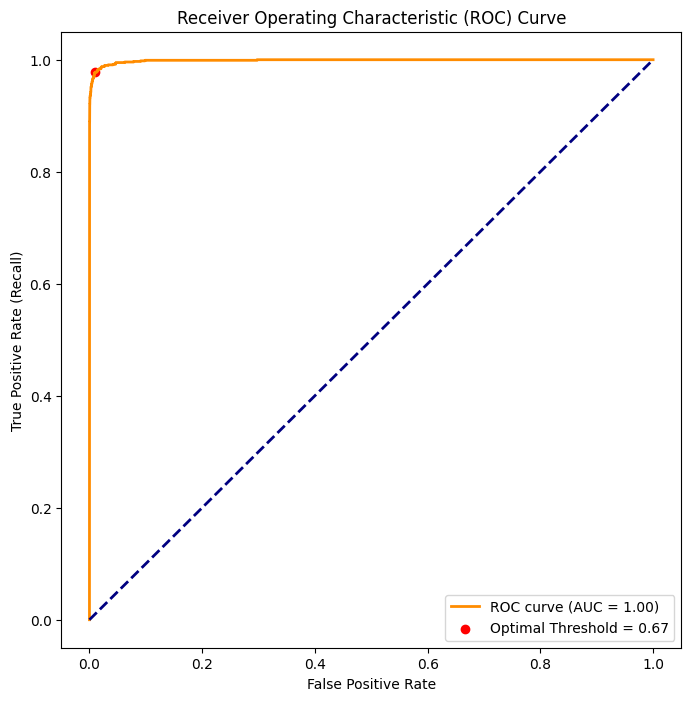

오차행렬:
 [[  959    23]
 [  101 10050]]

정확도: 0.9889
정밀도: 0.9047
재현율: 0.9766
F1: 0.9393


In [ ]:
# # 테스트 데이터에 대한 예측 확률을 얻음
pred_val = model.predict_proba(x_val.fillna(0))[:, 1]

# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(y_val, pred_val)

# AUC(Area Under the Curve) 계산
roc_auc = auc(fpr, tpr)

# ROC 곡선 및 AUC 출력
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# ROC 곡선에서의 적절한 임계값 선택
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
plt.scatter(fpr[optimal_threshold_idx], tpr[optimal_threshold_idx], marker='o', color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.legend(loc='lower right')

plt.show()

# 선택된 임계값을 사용하여 예측 클래스를 얻음
pred = (pred_val > optimal_threshold).astype(int)

get_clf_eval(y_val, pred)

In [ ]:
# threshold = 0.37 >> public score : 0.7541
# 최적의 값 : 0.46
threshold = 0.381

In [ ]:
pred_list = []
scores = []
for i,(tri, vai) in enumerate( stf.split(df_train, y_train) ):
    pred = models[i].predict_proba(df_train.iloc[vai])[:, 1]
    pred = np.where(pred >= threshold , 1, 0)
    score = f1_score(y_train[vai],pred)
    scores.append(score)
    pred = models[i].predict_proba(df_test)[:, 1]
    pred_list.append(pred)
print(scores)
print(np.mean(scores))

[0.6968503937007874, 0.6977671451355661, 0.7014028056112225, 0.7140536149471974, 0.7061207944872314]
0.703238950776401


In [ ]:
pred = np.mean( pred_list , axis = 0 )
pred = np.where(pred >= threshold , 1, 0)
sum(pred) # True로 예측된 개수

2199

## feature_importance

In [ ]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,idx_position,21.019839
1,lead_unit,19.617239
2,customer_idx,13.139347
3,customer_type,12.681342
4,idx_owner,5.194441
5,response_corporate,4.254902
6,country,3.717720
7,business_area,3.390235
8,lead_desc_length,3.211420
9,product_category,2.191123


# 4. ⭕ 제출하기

## 제출 파일 작성

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)
print("제출 파일 저장 완료")

제출 파일 저장 완료


**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**